#### 토픽 모델링이란?
- 단어들은 각각의 토픽을 가지고 있고 문장은 단어들을 가지고 있으며, 문서는 그러한 문장들을 가지고 있다.
- 이에 따라, 단어들의 토픽들을 알게 되면, 해당 문서에는 토픽들의 분포가 형성될 것이며, 크게는 해당 문서의 토픽을 알 수 있게 된다.

20 Newgoups 데이터세트로 토픽 모델링하기

In [2]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

stopwords는 불필요한 단어, 즉 조사나 관사들을 없애는 툴이다.

In [3]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

read_json 메소드로 웹에 있는 json 파일을 가지고 온다.

In [4]:
# Import Dataset
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
print(df.target_names.unique())
df.head()

['rec.autos' 'comp.sys.mac.hardware' 'rec.motorcycles' 'misc.forsale'
 'comp.os.ms-windows.misc' 'alt.atheism' 'comp.graphics'
 'rec.sport.baseball' 'rec.sport.hockey' 'sci.electronics' 'sci.space'
 'talk.politics.misc' 'sci.med' 'talk.politics.mideast'
 'soc.religion.christian' 'comp.windows.x' 'comp.sys.ibm.pc.hardware'
 'talk.politics.guns' 'talk.religion.misc' 'sci.crypt']


,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
10,From: irwin@cmptrc.lonestar.org (Irwin Arnstei...,8,rec.motorcycles
100,From: tchen@magnus.acs.ohio-state.edu (Tsung-K...,6,misc.forsale
1000,From: dabl2@nlm.nih.gov (Don A.B. Lindbergh)\n...,2,comp.os.ms-windows.misc


In [5]:
# Convert to list
data = df.content.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['From: (wheres my thing) Subject: WHAT car is this!? Nntp-Posting-Host: '
 'rac3.wam.umd.edu Organization: University of Maryland, College Park Lines: '
 '15 I was wondering if anyone out there could enlighten me on this car I saw '
 'the other day. It was a 2-door sports car, looked to be from the late 60s/ '
 'early 70s. It was called a Bricklin. The doors were really small. In '
 'addition, the front bumper was separate from the rest of the body. This is '
 'all I know. If anyone can tellme a model name, engine specs, years of '
 'production, where this car is made, history, or whatever info you have on '
 'this funky looking car, please e-mail. Thanks, - IL ---- brought to you by '
 'your neighborhood Lerxst ---- ']


- 정규식 표현을 통해서 문장 내에 이메일과 기타 특수 문자들을 없애주었지만, 여전히 난잡해보인다.
- LDA 알고리즘을 사용하기 위해서는, 문장들을 단어들의 묶음으로 변환시켜주는 과정이 필요하다.
- 이러한 과정을 Tokenization 이라고 한다.

# tokenization process

In [6]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  
        # deacc=True removes punctuations
        # 구두점(말끝에 찍는 쉼표나 점들을 의미) 을 없애주는 것이다.

data_words = list(sent_to_words(data))

print(data_words[:1])

[['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp', 'posting', 'host', 'rac', 'wam', 'umd', 'edu', 'organization', 'university', 'of', 'maryland', 'college', 'park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front', 'bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']]


### Bigram , Trigram 모델 만들기
- Bigram : 문서에서 함께 자주 등장하는 2개의 단어
- Trigram : 문서에서 함께 자주 등장하는 3개의 단어
- ‘front_bumper’, ‘oil_leak’, ‘maryland_college_park’ etc.
- Phrases : 모델을 빌드한다.
- min_count , threshold : Pharases 의 중요한 두 개의 파라미터
    - min_count (float, optional) : Ignore all words and bigrams with total collected count lower than this value.
    - threshold (float, optional) : Represent a score threshold for forming the phrases (higher means fewer phrases). A phrase of words a followed by b is accepted if the score of the phrase is greater than threshold. Heavily depends on concrete scoring-function, see the scoring parameter.

In [7]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

/home/hskimim/anaconda3/lib/python3.6/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp_posting_host', 'rac_wam_umd_edu', 'organization', 'university', 'of', 'maryland_college_park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front_bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']


In [8]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [9]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['where', 's', 'thing', 'car', 'nntp_post', 'host', 'rac_wam', 'umd', 'organization', 'university', 'maryland_college', 'park', 'line', 'wonder', 'anyone', 'could', 'enlighten', 'car', 'see', 'day', 'door', 'sport', 'car', 'look', 'late', 'early', 'call', 'bricklin', 'door', 'really', 'small', 'addition', 'front_bumper', 'separate', 'rest', 'body', 'know', 'anyone', 'tellme', 'model', 'name', 'engine', 'spec', 'year', 'production', 'car', 'make', 'history', 'whatev', 'info', 'funky', 'look', 'car', 'mail', 'thank', 'bring', 'neighborhood', 'lerxst']]


- LDA 모델에 들어가야 하는 두 가지 입력변수는 딕셔너리와(id2word) 코퍼스(corpus)이다.
- gensim 은 문서 내에 있는 단어별로 유니크한 아이디를 할당해준다.
- 아래의 각각의 엘리먼트 튜플당 의미하는 것은 [word_id,word_frequency] 이다.

In [10]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 2), (2, 1), (3, 1), (4, 1), (5, 1), (6, 5), (7, 1), (8, 1), (9, 2), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 2), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1)]]


만약 해당 id에 속한 단어를 보고싶으면

In [11]:
id2word[0]

'addition'

위의 표는 컴퓨터가 읽기 쉽게끔 만들어준 것이고, Counter 객체처럼 사람이 읽기 쉽게 만든 것은 아래와 같다.

In [ ]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('addition', 1),
  ('anyone', 2),
  ('body', 1),
  ('bricklin', 1),
  ('bring', 1),
  ('call', 1),
  ('car', 5),
  ('could', 1),
  ('day', 1),
  ('door', 2),
  ('early', 1),
  ('engine', 1),
  ('enlighten', 1),
  ('front_bumper', 1),
  ('funky', 1),
  ('history', 1),
  ('host', 1),
  ('info', 1),
  ('know', 1),
  ('late', 1),
  ('lerxst', 1),
  ('line', 1),
  ('look', 2),
  ('mail', 1),
  ('make', 1),
  ('maryland_college', 1),
  ('model', 1),
  ('name', 1),
  ('neighborhood', 1),
  ('nntp_post', 1),
  ('organization', 1),
  ('park', 1),
  ('production', 1),
  ('rac_wam', 1),
  ('really', 1),
  ('rest', 1),
  ('s', 1),
  ('see', 1),
  ('separate', 1),
  ('small', 1),
  ('spec', 1),
  ('sport', 1),
  ('tellme', 1),
  ('thank', 1),
  ('thing', 1),
  ('umd', 1),
  ('university', 1),
  ('whatev', 1),
  ('where', 1),
  ('wonder', 1),
  ('year', 1)]]

여태까지 해온 것이 LDA 모델 생성에 필요한 것들을 전부 한 것이다. 코퍼스와 딕셔너리를 생성한 것에 더해서, 우리는 몇 개의 토픽을 할당할 것인지에 대한 결정을 해주어야 한다.

- alpha , eta 는 토픽들의 떨어진 정도(sparsity)에 영향을 끼치는 하이퍼 파라미터이다. 도큐먼트에 따르면, 디폴트값은 1.0/num_topics prior 이다.
- chunksize 는 각각의 training chunk 에 사용될 문서의 갯수를 의미한다. 확실하지는 않지만, batch_size 와 유사한 의미를 갖는 것로 해석된다.

    - IN ADDITION : Text chunking, also referred to as shallow parsing, is a task that follows Part-Of-Speech Tagging and that adds more structure to the sentence. The result is a grouping of the words in “chunks”.


In [ ]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

위의 모델을 통해 반환되는 것은 토픽의 수는 20개이고 각각의 키워드(단어들의 집합)와 키워드들 간의 조합이 특정한 토픽의 가중치를 정해주는데 기여하는 것이다.

- lda_model 객체에 print_topics 메소드를 operating 하면, 각각의 키워드들이 토픽에 기여하는 가중치(importance)를 알 수 있다.
- 0부터 19까지 총 20개에 해당하는 토픽이 있는 것을 알 수 있고, 각각의 토픽에 위치해있는 키워드들과 이들 키워드들이 해당 토픽에서 가지는 중요도가 순서대로 나와있다.

In [ ]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

In [ ]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

pyLDAvis 만큼 jupyter notebook에서 LDA랄 잘 작동하면서 시각화하는 툴도 없다.

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

- Gensim 의 LDA 알고리즘보다 Mallet 버젼이 더 나은 퀄리티를 보여준다.
- https://www.machinelearningplus.com/wp-content/uploads/2018/03/mallet-2.0.8.zip 깔고 해당 경로를 아래에 넣어주면 된다.

In [ ]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = '/home/hskimim/Documents/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)
# Show Topics
pprint(ldamallet.show_topics(formatted=False))


In [ ]:
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

51에서 62로 Coherence Score 가 올라갔다.

#### LDA 에서 최적의 토픽 갯수 찾기
- 많은 LDA 모델을 토픽 갯수(k)를 다르게 해서, 많이 시행해본 후, Coherance value 가 가장 높은 것을 선택한다.
- 높은 Coherance Value 를 가지는 k를 선택하는 것은 유의미하고, 세부적인 토픽을 할당할 수 있게끔 한다.
- 여러개의 토픽에 키워드가 많이 중첩되면, 이것은 k를 너무 높게 할당했다는 신호가 될 수 있다.
- compute_coherence_values라는 메소드는 다수의 LDA 모델에 대한 Coherance value 를 알려준다.

In [41]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [42]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

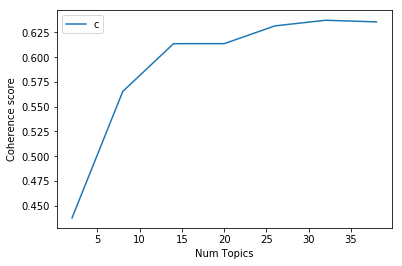

In [43]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [44]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4377
Num Topics = 8  has Coherence Value of 0.5654
Num Topics = 14  has Coherence Value of 0.6136
Num Topics = 20  has Coherence Value of 0.6137
Num Topics = 26  has Coherence Value of 0.6316
Num Topics = 32  has Coherence Value of 0.6373
Num Topics = 38  has Coherence Value of 0.6356


In [ ]:
optimal_model= gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=32, id2word=id2word)

#### 해당 문장에서 지배적인 토픽을 찾기
- 토픽 모델링의 주요 활용점은 해당 문서의 토픽이 무엇이냐에 관한 것이다.
- 이를 알아내기 위해서는 해당 문서에서 가장 기여를 많이 한, 즉 중요도가 가장 높은 토픽의 넘버를 찾아야 한다.
- format_topics_sentences() 메소드는 보여지는 테이블로 훌륭하게 정보를 병합해준다.

In [ ]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

#### 각각의 토픽을 대표하는 문서찾기
- 가끔 토픽 키워드(단어)는 단지 토픽들을 구성하는 것에 그치지 않는 경우가 있다.
- 토픽을 이해하는 것을 넘어서, 토픽을 형성하는데 가장 많은 기여를 한 문서를 찾아낼 수도 있다.

In [ ]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

#### 문서를 넘어선 토픽 분배
- 마지막으로 우리는 해당 정보에서 어떤 것들이 가장 많이 거론되었는지를 토픽의 크기(volume)과 분포(distribution)로 이해할 수 있게 된다.

In [ ]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.iloc[:10]